In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
import tensorflow as tf
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
url1 = 'C:\\Users\\86152\\Desktop\\LBMA-GOLD.csv'
df_gold = pd.read_csv(url1)
df_gold["Date"] = pd.to_datetime(df_gold["Date"], errors="coerce", format="%m/%d/%y")

In [3]:
#Preprocessing
def fill_na(data, column):
    '''fill the na values with the mean of adjacent values'''
    for i in range(1, len(data) - 1):
        if np.isnan(data[column].iloc[i]):
            adjacent_mean = (data[column].iloc[i - 1] + data[column].iloc[i + 1]) / 2
            data.at[i, column] = adjacent_mean
    return data

df_gold = fill_na(df_gold, "USD (PM)")
print(f"After cleaning, the num of missing values for gold prices is {df_gold['USD (PM)'].isna().sum()}")

After cleaning, the num of missing values for gold prices is 0


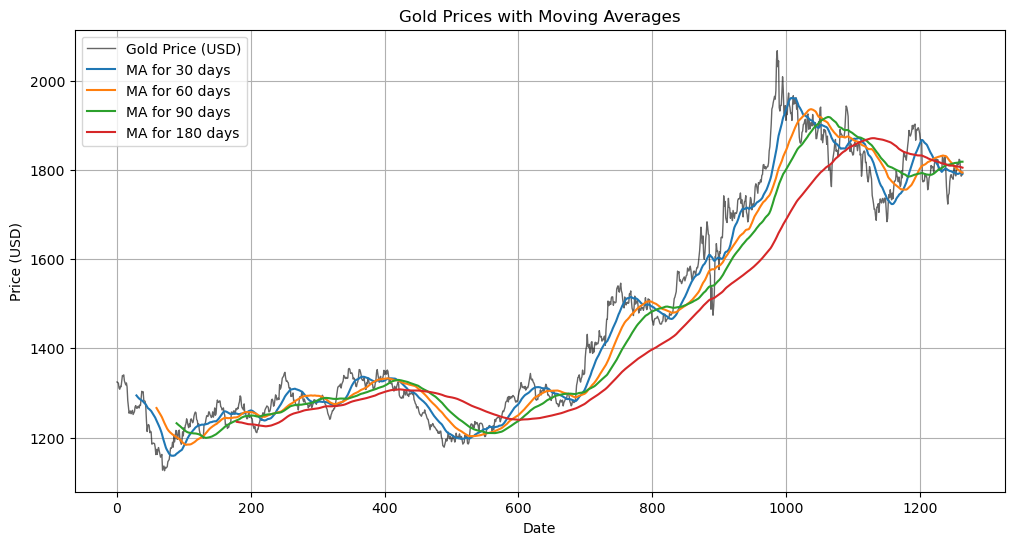

In [4]:
#Moving Average
ma_day = [30, 60, 90, 180]

for ma in ma_day:
    column_name = f"MA for {ma} days"
    df_gold[column_name] = df_gold['USD (PM)'].rolling(ma).mean()

plt.figure(figsize=(12, 6))
plt.plot(df_gold['USD (PM)'], label='Gold Price (USD)', linewidth=1, color='black', alpha=0.6)
for ma in ma_day:
    plt.plot(df_gold[f"MA for {ma} days"], label=f'MA for {ma} days')

# Add title, labels, and legend
plt.title('Gold Prices with Moving Averages')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid()
plt.show()

In [5]:
# Normalization
price = df_gold['USD (PM)'].values.reshape(-1, 1)
scaler = MinMaxScaler(feature_range=(0, 1))
price_scaled = scaler.fit_transform(price)

In [7]:
current_date = datetime.strptime('2021-08-10', '%Y-%m-%d')
predicted = {}
true = {}
abs = 0
for j in range(23):
    #Skip Weekend
    while current_date.weekday() >= 5: 
        current_date += timedelta(days=2)
    
    X, y = [], []
    for i in range(600, len(price_scaled) - 23 + j):#Here start ponit is 600. Adjust 600 if use other start ponit
        X.append(price_scaled[i-1:i, 0])#Here timestep is 1. Adjust 1 other timesteps
        y.append(price_scaled[i, 0])
    X, y = np.array(X), np.array(y)
    # Reshape X to the shape LSTM needs (samples, time steps, features)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    # Build LSTM Model
    model = Sequential()
    model.add(Input(shape=(X.shape[1], 1))) 
    model.add(LSTM(units=64, return_sequences=True))
    model.add(LSTM(units=64, return_sequences=True))
    model.add(LSTM(units=32))
    model.add(Dense(units=1))
    # Compile Model
    model.compile(optimizer='adam', loss='mean_squared_error')
    # Train Model
    model.fit(X, y, epochs=20, batch_size=32)#Change trainning epochs
    start_idx = -(23 - j + 1)#Here timestep is 1. Adjust 1 other timesteps
    end_idx = -(23 - j)
    input_data = price_scaled[start_idx:end_idx].reshape(1, 1, 1)#Here timestep is 1. Adjust the middle 1 if use other timesteps
    predicted_price = model.predict(input_data)
    true_price_new = price_scaled[-23 + j]
    abs += np.abs(predicted_price - true_price_new)
    # Anti-normalization
    future_price = []
    future_price.append(predicted_price[0, 0])
    future_price = scaler.inverse_transform(np.array(future_price).reshape(-1, 1))
    predicted[current_date] = future_price
    true_price = df_gold['USD (PM)'].values[-23 + j]
    true[current_date] = true_price
    print(current_date, true_price, future_price)
    current_date += timedelta(days=1)

print(f"Absolute Error: {abs}")
print(predicted)
            

Epoch 1/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.3357
Epoch 2/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.1790
Epoch 3/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 821us/step - loss: 0.0263
Epoch 4/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 840us/step - loss: 0.0180
Epoch 5/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step - loss: 0.0145
Epoch 6/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0106 
Epoch 7/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0069 
Epoch 8/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0041 
Epoch 9/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0020 
Epoch 10/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0015 
Epoch 11/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9.6271e-04
Epoch 12/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.6262e-04
Epoch 13/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7.8585e-04 
Epoch 14/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7.7355e-04 
Epoch 15/20
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - los

In [ ]:
#Save Dataframe
predicted_df = pd.DataFrame(
    [(date, value[0][0]) for date, value in predicted.items()],
    columns=['Date', 'Predicted Value']
)
import os
desktop_path = os.path.expanduser("~/Desktop/")
csv_filename = os.path.join(desktop_path, "df_gold_predicted2.csv")
predicted_df.to_csv(csv_filename, index=False)

print(f"DataFrame saved to {csv_filename}")

DataFrame saved to C:\Users\86152/Desktop/df_gold_predicted2.csv
